<a href="https://colab.research.google.com/github/gongx030/seatac_manuscript/blob/main/notebooks/seatac_GM12878_task1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Detecting the differential V-plots for down-sampled BAMs with different sizes

## Background

## Tasks

* Compare the performance of SeATAC, MACS2 and NucleoATAC on task 1.

## Setup

### Conda

```r421_py37_tf26```

### Install R packages

In [ ]:
required_packages <- c(
  'BiocManager', 'devtools', 'Matrix',
  'dplyr', 'tidyr', 'stringr',
  'pROC',
  'BSgenome.Hsapiens.UCSC.hg19'
)

In [ ]:
missing_packages <- required_packages[!required_packages %in% rownames(installed.packages())]
if (length(missing_packages) > 0){
    BiocManager::install(missing_packages)
}

In [ ]:
for (p in required_packages){
  library(p, character.only  = TRUE)
}

Bioconductor version '3.15' is out-of-date; the current release version '3.16'
  is available with R version '4.2'; see https://bioconductor.org/install

Loading required package: usethis


Attaching package: ‘devtools’


The following object is masked from ‘package:BiocManager’:

    install


Warning message:
“package ‘Matrix’ was built under R version 4.2.2”

Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Attaching package: ‘tidyr’


The following objects are masked from ‘package:Matrix’:

    expand, pack, unpack


Warning message:
“package ‘stringr’ was built under R version 4.2.2”
Type 'citation("pROC")' for a citation.


Attaching package: ‘pROC’


The following objects are masked from ‘package:stats’:

    cov, smooth, var


Loading required package: BSgenome

Loading required package: BiocGenerics


Attaching package: ‘BiocGe

### Install SeATAC from github

In [ ]:
devtools::load_all('../seatac')

ℹ Loading seatac
Loading required package: tensorflow

Warning message:
“package ‘tensorflow’ was built under R version 4.2.2”

Attaching package: ‘tensorflow’


The following object is masked from ‘package:rtracklayer’:

    import


Loading required package: tfprobability

Loading required package: tfdatasets

Loading required package: SummarizedExperiment

Loading required package: MatrixGenerics

Loading required package: matrixStats


Attaching package: ‘matrixStats’


The following object is masked from ‘package:dplyr’:

    count



Attaching package: ‘MatrixGenerics’


The following objects are masked from ‘package:matrixStats’:

    colAlls, colAnyNAs, colAnys, colAvgsPerRowSet, colCollapse,
    colCounts, colCummaxs, colCummins, colCumprods, colCumsums,
    colDiffs, colIQRDiffs, colIQRs, colLogSumExps, colMadDiffs,
    colMads, colMaxs, colMeans2, colMedians, colMins, colOrderStats,
    colProds, colQuantiles, colRanges, colRanks, colSdDiffs, colSds,
    colSums2, colTabulat

In [ ]:
#install_github('gongx030/seatac@v0.4.0', force = TRUE, quiet = FALSE)
#reload(pkgload::inst("seatac"))
#library(seatac)

## Parameters

In [ ]:
ARGS <- list(

  remote_macs2_summits_file = 'https://s3.msi.umn.edu/gongx030/datasets/dataset=Buenrostro_version=20170721a/GM12878_50k_cells_summits.bed',
  control_seed = 2L,
  positive_seed = 1L,
  negative_seed = 3L,
  pct = 0.1,
  shift_sizes = seq(10L, 100L, by = 10L),

  genome_version = 'hg19',

  block_size = 640L,
  step_size = 10L,
  min_reads_train = 10L,
  fragment_size_range_max = 640L,
  bin_size = 5L,
  fragment_size_interval = 10L,
  window_size = 2000L,
  sliding_step = 10L,
  min_peaks = 10000L,
  max_peaks = 200000L,
  batch_size = 256,
  epochs = 100L
)

In [ ]:
remote_shift_bam_files <- sprintf('https://s3.msi.umn.edu/gongx030/datasets/dataset=Buenrostro_version=20170721a/GM12878_50k_cells_seed=%d_pct=%.4f_shift=%d.bam', ARGS$positive_seed, ARGS$pct, ARGS$shift_sizes)
names(remote_shift_bam_files) <- sprintf('positive_shift_%d', ARGS$shift_sizes)

In [ ]:
ARGS$remote_bam_files = c(
  control = sprintf('https://s3.msi.umn.edu/gongx030/datasets/dataset=Buenrostro_version=20170721a/GM12878_50k_cells_seed=%d_pct=%.4f.bam', ARGS$control_seed, ARGS$pct),
  negative = sprintf('https://s3.msi.umn.edu/gongx030/datasets/dataset=Buenrostro_version=20170721a/GM12878_50k_cells_seed=%d_pct=%.4f.bam', ARGS$negative_seed, ARGS$pct),
  remote_shift_bam_files
)

In [ ]:
ARGS$local_bam_files <- gsub('https://', './', ARGS$remote_bam_files)
stopifnot(all(file.exists(ARGS$local_bam_files)))

In [ ]:
ARGS$local_macs2_summits_file <- gsub('https://', './', ARGS$remote_macs2_summits_file)
stopifnot(file.exists(ARGS$local_macs2_summits_file))

In [ ]:
ARGS$remote_macs2_bw_file <- gsub('.bam', '_treat_pileup.bw', ARGS$remote_bam_files)
ARGS$local_macs2_bw_file <- gsub('https://', './', ARGS$remote_macs2_bw_file)
stopifnot(file.exists(ARGS$local_macs2_bw_file))

In [ ]:
ARGS$remote_nuceoatac_file <- gsub('.bam', '.nucleoatac_signal.smooth.bw', ARGS$remote_bam_files)
ARGS$local_nuceoatac_file <- gsub('https://', './', ARGS$remote_nuceoatac_file)
stopifnot(file.exists(ARGS$local_nuceoatac_file))

## Training SeATAC

In [ ]:
devtools::load_all('../seatac')
devtools::load_all('../bpt')

ℹ Loading seatac
Creating a new generic function for ‘fit’ in package ‘seatac’

Creating a new generic function for ‘predict’ in package ‘seatac’

ℹ Loading bpt
Warning message:
“replacing previous import ‘GenomicRanges::union’ by ‘dplyr::union’ when loading ‘bpt’”
Warning message:
“replacing previous import ‘GenomicRanges::intersect’ by ‘dplyr::intersect’ when loading ‘bpt’”
Warning message:
“replacing previous import ‘GenomicRanges::setdiff’ by ‘dplyr::setdiff’ when loading ‘bpt’”


In [ ]:
sprintf('reading %s', ARGS$local_macs2_summits_file) %>% message()
gr <- read.table(ARGS$local_macs2_summits_file, header = TRUE, sep = '\t')
gr <- GRanges(seqnames = gr[, 1], ranges = IRanges(gr[, 2], gr[, 3]))
gr <- gr[as.character(seqnames(gr)) %in% sprintf('chr%s', c(1:22, 'X'))]
gr <- resize(gr, width = ARGS$window_size, fix = 'center')
gr <- slidingWindows(gr, width = ARGS$block_size, step = ARGS$step_size) %>% unlist()
sprintf('total blocks: %d', length(gr)) %>% message()
set.seed(1L)
gr <- sample(gr, min(length(gr), ARGS$max_peaks))

reading ./s3.msi.umn.edu/gongx030/datasets/dataset=Buenrostro_version=20170721a/GM12878_50k_cells_summits.bed

total blocks: 14303348



In [ ]:
counts <- count_reads(gr, ARGS$local_bam_files, genome = BSgenome.Hsapiens.UCSC.hg19,  fragment_size_range = c(0, ARGS$fragment_size_range_max))

Warning message in valid.GenomicRanges.seqinfo(x, suggest.trim = TRUE):
“GRanges object contains 1 out-of-bound range located on sequence chr17.
  Note that ranges located on a sequence whose length is unknown (NA) or
  on a circular sequence are not considered out-of-bound (use
  seqlengths() and isCircular() to get the lengths and circularity flags
  of the underlying sequences). You can use trim() to trim these ranges.
  See ?`trim,GenomicRanges-method` for more information.”
read_bam | reading ./s3.msi.umn.edu/gongx030/datasets/dataset=Buenrostro_version=20170721a/GM12878_50k_cells_seed=2_pct=0.1000.bam

Warning message in valid.GenomicRanges.seqinfo(x, suggest.trim = TRUE):
“GRanges object contains 3 out-of-bound ranges located on sequence
  chr17. Note that ranges located on a sequence whose length is unknown
  (NA) or on a circular sequence are not considered out-of-bound (use
  seqlengths() and isCircular() to get the lengths and circularity flags
  of the underlying sequences)

In [ ]:
valid <- rowSums(counts >= ARGS$min_reads_train) >= 2L
sprintf('number of valid peaks for VaeModel: %d', sum(valid)) %>% message()

number of valid peaks for VaeModel: 60934



In [ ]:
gr <- gr[valid]
gr <- sample(gr, min(length(gr), ARGS$min_peaks))
sprintf('sampling %d valid peaks for training VaeModel', length(gr)) %>% message()

sampling 10000 valid peaks for training VaeModel



In [ ]:
x <- read_vplot(
  gr, 
  filenames = ARGS$local_bam_files, 
  genome = BSgenome.Hsapiens.UCSC.hg19, 
  bin_size = ARGS$bin_size,
  fragment_size_range = c(0, ARGS$fragment_size_range_max),
  fragment_size_interval = ARGS$fragment_size_interval
)

read_bam | reading ./s3.msi.umn.edu/gongx030/datasets/dataset=Buenrostro_version=20170721a/GM12878_50k_cells_seed=2_pct=0.1000.bam

as(<ngCMatrix>, "dgCMatrix") is deprecated since Matrix 1.5-0; do as(., "dMatrix") instead

read_bam | reading ./s3.msi.umn.edu/gongx030/datasets/dataset=Buenrostro_version=20170721a/GM12878_50k_cells_seed=3_pct=0.1000.bam

read_bam | reading ./s3.msi.umn.edu/gongx030/datasets/dataset=Buenrostro_version=20170721a/GM12878_50k_cells_seed=1_pct=0.1000_shift=10.bam

read_bam | reading ./s3.msi.umn.edu/gongx030/datasets/dataset=Buenrostro_version=20170721a/GM12878_50k_cells_seed=1_pct=0.1000_shift=20.bam

read_bam | reading ./s3.msi.umn.edu/gongx030/datasets/dataset=Buenrostro_version=20170721a/GM12878_50k_cells_seed=1_pct=0.1000_shift=30.bam

read_bam | reading ./s3.msi.umn.edu/gongx030/datasets/dataset=Buenrostro_version=20170721a/GM12878_50k_cells_seed=1_pct=0.1000_shift=40.bam

read_bam | reading ./s3.msi.umn.edu/gongx030/datasets/dataset=Buenrostro_version

In [ ]:
# Training SeATAC
model <- VaeModel(x)
model <- model %>% fit(x, batch_size = ARGS$batch_size, epochs = ARGS$epochs, compile = TRUE)

epoch=     1/   100 | beta=1.000e+00 | loss= 6031.8035400 | loss_reconstruction= 6029.8581543 | loss_kl=    1.9453825

epoch=     2/   100 | beta=1.000e+00 | loss= 4372.9796997 | loss_reconstruction= 4372.1423218 | loss_kl=    0.8373787

epoch=     3/   100 | beta=1.000e+00 | loss= 2080.2084000 | loss_reconstruction= 2080.1312225 | loss_kl=    0.0771676

epoch=     4/   100 | beta=1.000e+00 | loss=  543.2316437 | loss_reconstruction=  543.2158142 | loss_kl=    0.0158302

epoch=     5/   100 | beta=1.000e+00 | loss=  224.4986679 | loss_reconstruction=  224.4776665 | loss_kl=    0.0210006

epoch=     6/   100 | beta=1.000e+00 | loss=  162.1627625 | loss_reconstruction=  162.1015160 | loss_kl=    0.0612463

epoch=     7/   100 | beta=1.000e+00 | loss=  142.8260628 | loss_reconstruction=  142.6346214 | loss_kl=    0.1914409

epoch=     8/   100 | beta=1.000e+00 | loss=  134.6969122 | loss_reconstruction=  134.1830244 | loss_kl=    0.5138871

epoch=     9/   100 | beta=1.000e+00 | loss=  13

## ROC at shift size of 50

In [ ]:
x <- model %>% predict(x, vplots = FALSE) # predicting nucleosomes on regions with ground truth

In [ ]:
sample_negative <- 'negative'
sample_control <- 'control'

In [ ]:
res_seatac <- NULL
auc_seatac <- NULL
for (shift_size in ARGS$shift_sizes){
  sample_positive <- sprintf('positive_shift_%d', shift_size)
  res_neg <- model %>% results(x, type = 'vplots', contrast = c('name', sample_control, sample_negative))
  res_neg$class <- 'negative' # regions without any V-plot changes (seed 1 vs seed 2)
  res_pos <- model %>% results(x, type = 'vplots', contrast = c('name', sample_control, sample_positive))
  res_pos$class <- 'positive' # regions with significant V-plot changes (seed 1 vs seed 2 + shift)
  res <- c(res_neg, res_pos)
  roc <- roc(res$class, res$pvalue_z, plot = FALSE, quiet = TRUE) # differential V-plots as estimated by the SeATAC p-value
  res_seatac <- rbind(res_seatac, cbind(coords(roc), shift_size = shift_size))
  auc_seatac <- rbind(auc_seatac, data.frame(shift_size = shift_size, auc = roc$auc))
  sprintf('shift_size=%d, roc=%.3f', shift_size, roc$auc) %>% message()
}

shift_size=10, roc=0.964

shift_size=20, roc=0.977

shift_size=30, roc=0.985

shift_size=40, roc=0.990

shift_size=50, roc=0.994

shift_size=60, roc=0.995

shift_size=70, roc=0.996

shift_size=80, roc=0.997

shift_size=90, roc=0.998

shift_size=100, roc=0.998



In [ ]:
res_macs2 <- NULL
auc_macs2 <- NULL
for (shift_size in ARGS$shift_sizes){
  sample_positive <- sprintf('positive_shift_%d', shift_size)
  cvg <- rtracklayer::import(ARGS$local_macs2_bw_file[sample_control], which = gr, format = 'BigWig', as = 'RleList')
  control <- cvg[gr] %>% as.matrix() 
  cvg <- rtracklayer::import(ARGS$local_macs2_bw_file[sample_positive], which = gr, format = 'BigWig', as = 'RleList')
  positive <- cvg[gr] %>% as.matrix() 
  cvg <- rtracklayer::import(ARGS$local_macs2_bw_file[sample_negative], which = gr, format = 'BigWig', as = 'RleList')
  negative <- cvg[gr] %>% as.matrix() 
  res_neg <- rowMaxs(abs(negative - control)) # maximum differential MACS2 pileup between control and negative (no change of V-plots, seed 1 vs seed 2)
  res_pos <- rowMaxs(abs(positive - control)) # maximum differential MACS2 pileup between control and positive (significant change of V-plots, seed 1 vs seed 2 + shift)
  class <- rep(c('negative', 'positive'), each = length(gr))
  score <- c(res_neg, res_pos)
  roc <- roc(class, score, plot = FALSE, quiet = TRUE) # differential V-plots as estimated by the MACS2 score
  res_macs2 <- rbind(res_macs2, cbind(coords(roc), shift_size = shift_size))
  auc_macs2 <- rbind(auc_macs2, data.frame(shift_size = shift_size, auc = roc$auc))
  sprintf('shift_size=%d, roc=%.3f', shift_size, roc$auc) %>% message()
}

shift_size=10, roc=0.525

shift_size=20, roc=0.530

shift_size=30, roc=0.533

shift_size=40, roc=0.536

shift_size=50, roc=0.538

shift_size=60, roc=0.538

shift_size=70, roc=0.541

shift_size=80, roc=0.542

shift_size=90, roc=0.543

shift_size=100, roc=0.544



In [ ]:
res_nucleoatac <- NULL
auc_nucleoatac <- NULL
for (shift_size in ARGS$shift_sizes){
  sample_positive <- sprintf('positive_shift_%d', shift_size)
  cvg <- rtracklayer::import(ARGS$local_nuceoatac_file[sample_control], which = gr, format = 'BigWig', as = 'RleList')
  control <- cvg[gr] %>% as.matrix() 
  cvg <- rtracklayer::import(ARGS$local_nuceoatac_file[sample_positive], which = gr, format = 'BigWig', as = 'RleList')
  positive <- cvg[gr] %>% as.matrix() 
  cvg <- rtracklayer::import(ARGS$local_nuceoatac_file[sample_negative], which = gr, format = 'BigWig', as = 'RleList')
  negative <- cvg[gr] %>% as.matrix() 
  res_neg <- rowMaxs(abs(negative - control)) # maximum differential NucleoATAC pileup between control and negative (no change of V-plots, seed 1 vs seed 2)
  res_pos <- rowMaxs(abs(positive - control)) # maximum differential NucleoATAC pileup between control and positive (significant change of V-plots, seed 1 vs seed 2 + shift)
  class <- rep(c('negative', 'positive'), each = length(gr))
  score <- c(res_neg, res_pos)
  roc <- roc(class, score, plot = FALSE, quiet = TRUE) # differential V-plots as estimated by the NucleoATAC score
  res_nucleoatac <- rbind(res_nucleoatac, cbind(coords(roc), shift_size = shift_size))
  auc_nucleoatac <- rbind(auc_nucleoatac, data.frame(shift_size = shift_size, auc = roc$auc))
  sprintf('shift_size=%d, roc=%.3f', shift_size, roc$auc) %>% message()
}


shift_size=10, roc=0.502

shift_size=20, roc=0.510

shift_size=30, roc=0.520

shift_size=40, roc=0.529

shift_size=50, roc=0.536

shift_size=60, roc=0.541

shift_size=70, roc=0.544

shift_size=80, roc=0.547

shift_size=90, roc=0.549

shift_size=100, roc=0.549



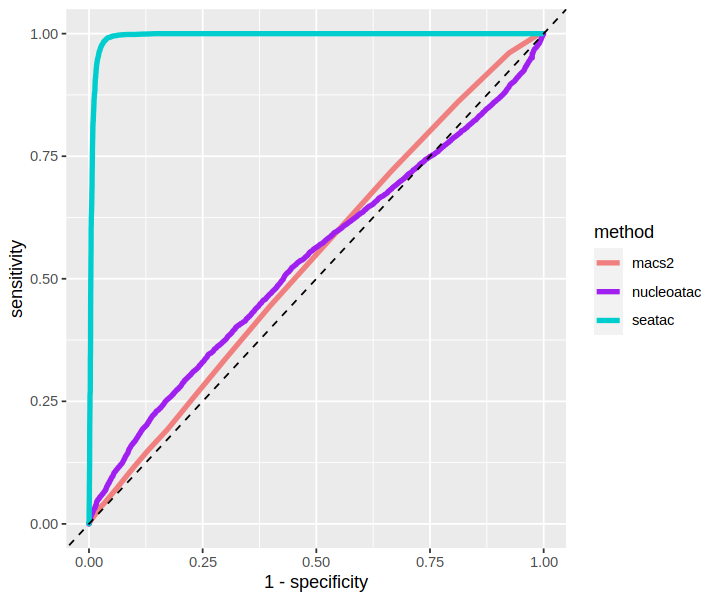

In [ ]:
options(repr.plot.width = 6, repr.plot.height = 5)
rbind(
  cbind(res_seatac, method = 'seatac'),
  cbind(res_macs2, method = 'macs2'),
  cbind(res_nucleoatac, method = 'nucleoatac')
) %>%
  filter(shift_size == 50) %>%
  ggplot(aes(y = sensitivity, x = 1 - specificity, color = method)) +
    geom_line(linewidth = 1.5) +
    geom_abline(intercept = 0, slope = 1, linetype = 'dashed') + 
    scale_color_manual(values= c(macs2 = 'lightcoral', nucleoatac = 'purple', seatac = 'cyan3')) +
    scale_fill_manual(values= c(macs2 = 'lightcoral', nucleoatac = 'purple', seatac = 'cyan3'))

## Shift size vs. AUC

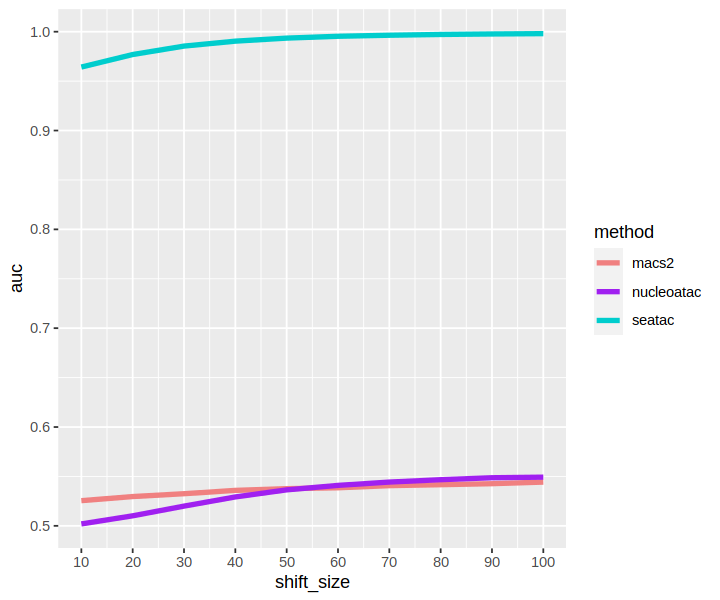

In [ ]:
options(repr.plot.width = 6, repr.plot.height = 5)
rbind(
  cbind(auc_seatac, method = 'seatac'),
  cbind(auc_macs2, method = 'macs2'),
  cbind(auc_nucleoatac, method = 'nucleoatac')
) %>%
  ggplot(aes(x = shift_size, y = auc, color = method)) +
    geom_line(linewidth = 1.5) +
    scale_color_manual(values= c(macs2 = 'lightcoral', nucleoatac = 'purple', seatac = 'cyan3')) +
    scale_fill_manual(values= c(macs2 = 'lightcoral', nucleoatac = 'purple', seatac = 'cyan3')) +
    scale_x_continuous(breaks = seq(10, 100, by = 10))

## SessionInfo

In [ ]:
sessionInfo()

R version 4.2.1 (2022-06-23)
Platform: x86_64-conda-linux-gnu (64-bit)
Running under: CentOS Linux 7 (Core)

Matrix products: default
BLAS/LAPACK: /panfs/jay/groups/18/garrydj/gongx030/.conda/envs/r421_py37_tf26/lib/libopenblasp-r0.3.21.so

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] stats4    stats     graphics  grDevices utils     datasets  methods  
[8] base     

other attached packages:
 [1] bpt_0.1.005                       seatac_0.4.2-002                 
 [3] SummarizedExperiment_1.26.1       Biobase_2.56.0                   
 [5] MatrixGenerics_1.8.1              matrixStats_0.63.0               
 [7] tfdatasets_2.9.0                  